In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Construct Lagrange basis functions

The $i$-th Lagrange polynomial associated to $x_i$, evaluated at $x$, is defined as:
$$
l_i(x) := \prod_{j=0, j\neq i}^{n} \frac{x-x_j}{x_i-x_j}.
$$

In this lecture we take advantage of `numpy` implementation of Polynomials:

In [2]:
from numpy.polynomial.polynomial import Polynomial

Let `q` be a given array of points $\{x_i\}$ with $i = 0\ldots n-1$.

In [3]:
n = 6
q = linspace(0,1,n)

We construct a list of Polynomial objects. Each of the entries will correspond to the $l_i(x)$ basis functions associated to $x_i$ stored in the array `q`.

The following two code lines can seem cryptic at a first glance. In programming idiom they are called *one-liners*, they perform non trivial tasks on a single line. Here we write in explicit form each command unit, hoping that the reader will appreciate the one to one relationship, in between mathematical formulation and python syntax.

First, we initialize the list of basis functions:
```
L = [].
```
We will need to populate it, with the basis functions that range from $0$ to $n$. 
$$L = \{l_i(x)\}_{i=0}^{n-1}$$

$$
\begin{array}{l c r}
\mathtt{L\ =\ [}\ l_i(x) & \quad \forall i = 0\ldots n-1 & \mathtt{]} \\
\mathtt{L\ =\ [}\ l_i(x) & \quad \mathtt{for\ i\ in \ range(n)} & \mathtt{]}
\end{array}
$$

$l_i(x)$ is the polynomial with the set of roots $\{x_j\}_{j=0, \, j\neq i}^{n-1}\subset\{x_i\}_{i=0}^{n-1}$. We should have already guessed that that the mathematical symbol for a set $\{\cdot\}$ translates to python syntax for a list `[]`, then:


$$
\begin{array}{l l l}
\mathtt{[}x_j,& \quad \forall x_j\ \in \{x_i\}_{i=0}^{n-1},  & \mathrm{if}\ j\neq i \mathtt{]} \\
\mathtt{[}x_j,& \quad \mathrm{for}\ x_j\ \mathrm{in}\ \mathtt{q}\ & \mathtt{if}\ x_j\neq x_i \mathtt{]}\\
\mathtt{[xj}& \quad \mathrm{for}\ \mathtt{xj}\ \mathrm{in}\ \mathtt{q}\ & \mathtt{if}\ \mathtt{xj\ !=\ q[i]} \mathtt{]}.
\end{array}
$$

Now the first *one-liner* should be clearly defined as the set of polynomials
$$
\{l_i(x), \mathrm{such\ that}\ l_i(\{x_j\}_{j=0, \, j\neq i}^{n-1})=0\}_{i=0}^{n-1}
$$

In [4]:
L = [Polynomial.fromroots([xj for xj in q if xj != q[i]]) for i in range(n)]

The second condition we wish to impose is: $l_i(x_j)=\delta_{ij}$. This can be seen as a rescale of the previous set:
$$
\left\{l_i(x), \mathrm{such\ that}\ l_i(x) = \frac{l_i(x)}{l_i(x_i)} \right\}_{i=0}^{n-1}
$$

In [5]:
L = [L[i]/L[i](q[i]) for i in range(n)]

In [6]:
type(L[0])
print(L[0])

poly([  1.         -11.41666667  46.875      -88.54166667  78.125      -26.04166667])


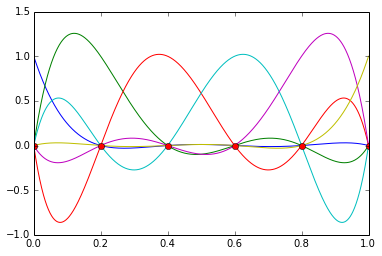

In [7]:
x = linspace(0,1,1025)
for f in L:
    plot(x, f(x))
plot(q, 0*q, 'ro')

# Poisson's Problem

Approximating an unknown function $u(s)$ with its discrete representation $u_h(s)$, is a powerful strategy in solving PDEs. Number of physical problems can be modeled building on the Poisson's problem:


Find $u(s) \in C^2([0,1])$ s.t.
$$
-u''(s) = f(s)\ \mathrm{in}\  [0,1]
$$

$$
u(0) = 0, \quad u'(1) = 1.
$$

Finding a solution $u(s)$ might seem to ambitious. This is why we lower our expetctations and construct a discrete solution as a linear combination of known basis functions, $u_h(s) :=  u^i l_i(s)$. The original problem can be rewritten:

Find $u_h(s) :=  u^i l_i(s)$ s.t.

$$
-u_h''(s) = f(s)\ \mathrm{ in }\ [0,1]
$$

$$
u_h(0) = 0, \quad u_h'(1) = 1
$$

"Just plug $h$ everywhere!" F. Brezzi.

Before proceeding, we notice that first and second derivatives are involved in our problem. It sounds then a good to prepare two lists storing these informations:

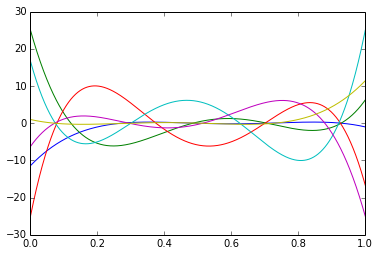

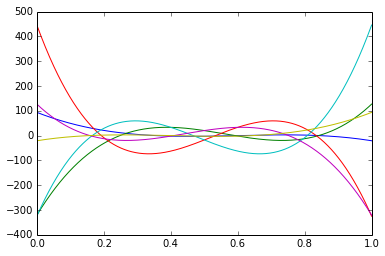

In [8]:
L_prime = [L[i].deriv() for i in range(n)]
L_prime_prime = [L[i].deriv().deriv() for i in range(n)]

for f in L_prime:
    plot(x, f(x))

show()

for f in L_prime_prime:
    plot(x, f(x))

show()


The continuous problem discretisation isolated the problem in finding the $n$ coefficients $u^i$.
The first step is to focus on the condition that has to be satisfied inside the domain:
$$
-u_h''(s) := f(s).
$$
From linearity we can write: 
$$
-u_h''(s) := -l_i''(s)\ u^i.
$$

$$
-l_i''(s)\ u^i := f(s) \quad \forall s\ \mathrm{in}\ [0,1]\subset \mathbb{R} 
$$
The discrete problem is now finding the $n$ coefficients $u_i$. We notice that the last equation is true for the infinite number of values $s$. We only need $n$ choices of $s$ to close our problem. Choose $s = x_j$, for $j = 0, \dots, n$.

We get the following:
$$
-l_i''(x_j)\ u^i := f(x_j) \quad \forall x_j\ \mathrm{in}\ \{x_j\}_{j=0}^n.
$$

We can write the problem in matrix form:

$$
A u = b,
$$

defining

$$
A_{ij} := -l_j''(x_i) \quad i,j = 0, \dots, n-1
$$

and,

$$
b_i := f(x_i) \quad i = 0, \dots, n-1.
$$

Chosing as evaluation points those stored in the array `q`, we get:

In [9]:
A = zeros((n,n))
for i in range(n):
    A[:,i] = -L_prime_prime[i](q)

### Control
Consider, $g(x)\in \mathrm{span}\{l_i(x)\}$, and $\{x_i\}_{i=0}^{n-1}$. We write:
$$
\left(
\begin{array}{c}
u(x_0)\\
u(x_1)\\
\vdots\\
u(x_{n-1})\\
\end{array}
\right) = 
\left(
\begin{array}{cccc}
l_0(x_0) & l_1(x_0) & \cdots & l_{n-1}(x_0) \\
l_0(x_1) & l_1(x_1) & \cdots & l_{n-1}(x_1) \\
\vdots & \vdots & \ddots & \vdots \\
l_0(x_{n-1}) & l_1(x_{n-1}) & \cdots & l_{n-1}(x_{n-1}) \\
\end{array}
\right)
\left(
\begin{array}{c}
u(x_0)\\
u(x_1)\\
\vdots\\
u(x_{n-1})\\
\end{array}
\right)
$$
Since $g(x)\in \mathrm{span}\{l_i(x)\}$, we have:
$$
\left(
\begin{array}{c}
u(x)
\end{array}
\right) = 
\left(
\begin{array}{cccc}
l_0(x) & l_1(x) & \cdots & l_{n-1}(x) 
\end{array}
\right)
\left(
\begin{array}{c}
u(x_0)\\
u(x_1)\\
\vdots\\
u(x_{n-1})\\
\end{array}
\right)
$$
We can write $u''(x)$ as:
$$
\left(
\begin{array}{c}
u''(x)
\end{array}
\right) = 
\left(
\begin{array}{cccc}
l''_0(x) & l''_1(x) & \cdots & l''_{n-1}(x) 
\end{array}
\right)
\left(
\begin{array}{c}
u(x_0)\\
u(x_1)\\
\vdots\\
u(x_{n-1})\\
\end{array}
\right)
$$
If we specify again the exaluation points $\{x_i\}_{i=0}^{n-1}$:
$$
\left(
\begin{array}{c}
u''(x_0)\\
u''(x_1)\\
\vdots\\
u''(x_{n-1})\\
\end{array}
\right) = 
\left(
\begin{array}{cccc}
l''_0(x_0) & l''_1(x_0) & \cdots & l''_{n-1}(x_0) \\
l''_0(x_1) & l''_1(x_1) & \cdots & l''_{n-1}(x_1) \\
\vdots & \vdots & \ddots & \vdots \\
l''_0(x_{n-1}) & l''_1(x_{n-1}) & \cdots & l''_{n-1}(x_{n-1}) \\
\end{array}
\right)
\left(
\begin{array}{c}
u(x_0)\\
u(x_1)\\
\vdots\\
u(x_{n-1})\\
\end{array}
\right)
$$
This is a good way to control whether we assembled correctely $A_{ij}$:
$$
u''(x_i) = A_{ij} u(x_j)\quad j = 0, 1, \ldots, n-1
$$

In [10]:
g = q**2
A.dot(g)

array([-2., -2., -2., -2., -2., -2.])

It is interesting controlling the condition number of our matrix $A$

In [11]:
from numpy.linalg import cond
cond(A)

29621719097768976.0

The number we obtain is extremely high, meaning the matrix, as it is, is not a good condate to be resolved.

We write the following two arrays:
$$
\mathtt{bc0} = \{l_i(0)\}_{i=0}^{n-1}
$$
$$
\mathtt{bc1} = \{l_i'(1)\}_{i=0}^{n-1}
$$

In [12]:
bc0 = array([L[i](0) for i in range(n)])
bc1 = array([L_prime[i](1) for i in range(n)])

As these array refer to the first, and last evaluation point, it is coherent to substitute the first and last rows of $A$. The condition number will be much more reasonable.

In [13]:
A[0,:] = bc0
A[-1] = bc1

In [14]:
cond(A)

326.43605179356661

The right hand side of our system will be the simple evaluation of $f(s)$, that we will fix as $f(s) = 4\pi^2\sin(2\pi\ q)$

In [15]:
rhs = 4*pi**2*sin(2*pi*q)

The boundary conditions will be matched setting:
$$
\mathtt{bc0} = \{l_i(0)\}_{i=0}^{n-1} = \mathtt{rhs[0]} = 0
$$
$$
\mathtt{bc1} = \{l_i'(1)\}_{i=0}^{n-1} = \mathtt{rhs[n]} = 1
$$

In [16]:
rhs[0] = 0
rhs[-1] =  1

In [17]:
u = solve(A, rhs)

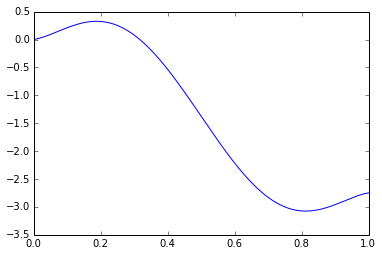

In [18]:
Lu = sum([L[i]*u[i] for i in range(n)])
Lsin = sum([L[i]*sin(2*pi*q[i]) for i in range(n)])

plot(x, Lu(x))

Suggested exercises:

 - Choose a *manufactured* solution $u(s)$, set $f(s) = -u''(s)$ and solve again the problem. Choose boundary conditions in manner that will fit your solution.
 - Compare the condition number for $A$ evaluated at equispaced points and Chebyshev nodes.
 - Plot in the same figure $||u-u_h||_\infty$ for both equispaced and Chebyshev nodes increasing values of $n$.